In [33]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

from gradvi.tests import toy_data
from gradvi.tests import toy_priors
from gradvi.inference import LinearRegression
from gradvi.inference import Trendfiltering
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma

from mrashpen.utils import R_trendfilter

In [34]:
np.random.seed(100)

#dims = np.power(2, 7 + np.arange(2))
n = 1024
data = dict()
degree = 1
nknots = 20
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

# Gamma signal
def sample_sign(n, f = 0.5):
    return np.random.choice([-1, 1], size=n, p=[f, 1 - f])
params = [10, 0.1]
np.random.seed(100)
bfix = np.random.gamma(params[0], params[1], size = nknots + degree)
bfix = np.multiply(bfix, sample_sign(nknots + degree))


x = np.linspace(0, 1, n)
data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                signal = "fixed", seed = 100, bfix = bfix,
                include_intercept = False)

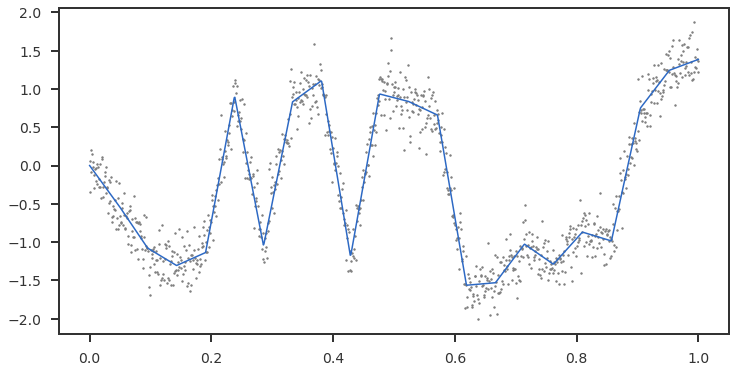

In [35]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
ax1.scatter(data.x, data.y, s = 2, color = 'grey')
ax1.plot(data.x, data.ytrue)
plt.show()

In [36]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)
tf_bhat  = np.dot(data.Hinv, tf_y)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



In [37]:
## Genlasso Init

prior_init = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2.0, skfactor = 10)
gv1 = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = True)
gv1.fit(data.y, degree, prior_init, y_init = tf_y)

In [38]:
gv1.prior.w

array([9.84861041e-01, 9.65567100e-04, 8.56233035e-04, 8.23050556e-04,
       8.07086197e-04, 7.97714050e-04, 7.91555240e-04, 7.87202047e-04,
       7.83963941e-04, 7.81462583e-04, 7.79473349e-04, 7.77854484e-04,
       7.76512116e-04, 7.75381617e-04, 7.74417041e-04, 7.73584827e-04,
       7.72859889e-04, 7.72223101e-04, 7.71659628e-04, 7.71157784e-04])

In [48]:
## Moving average init

prior_init = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2.0, skfactor = 10)
gv2 = Trendfiltering(maxiter = 20000, standardize_basis = False, standardize = False)
gv2.fit(data.y, degree, prior_init)

In [45]:
gv2.prior.w

array([0.17996381, 0.20909526, 0.0621881 , 0.04549735, 0.03938866,
       0.03625041, 0.03434611, 0.03306974, 0.03215569, 0.03146945,
       0.03093569, 0.03050894, 0.03016017, 0.02986999, 0.02962491,
       0.0294153 , 0.02923408, 0.02907595, 0.02893684, 0.02881358])

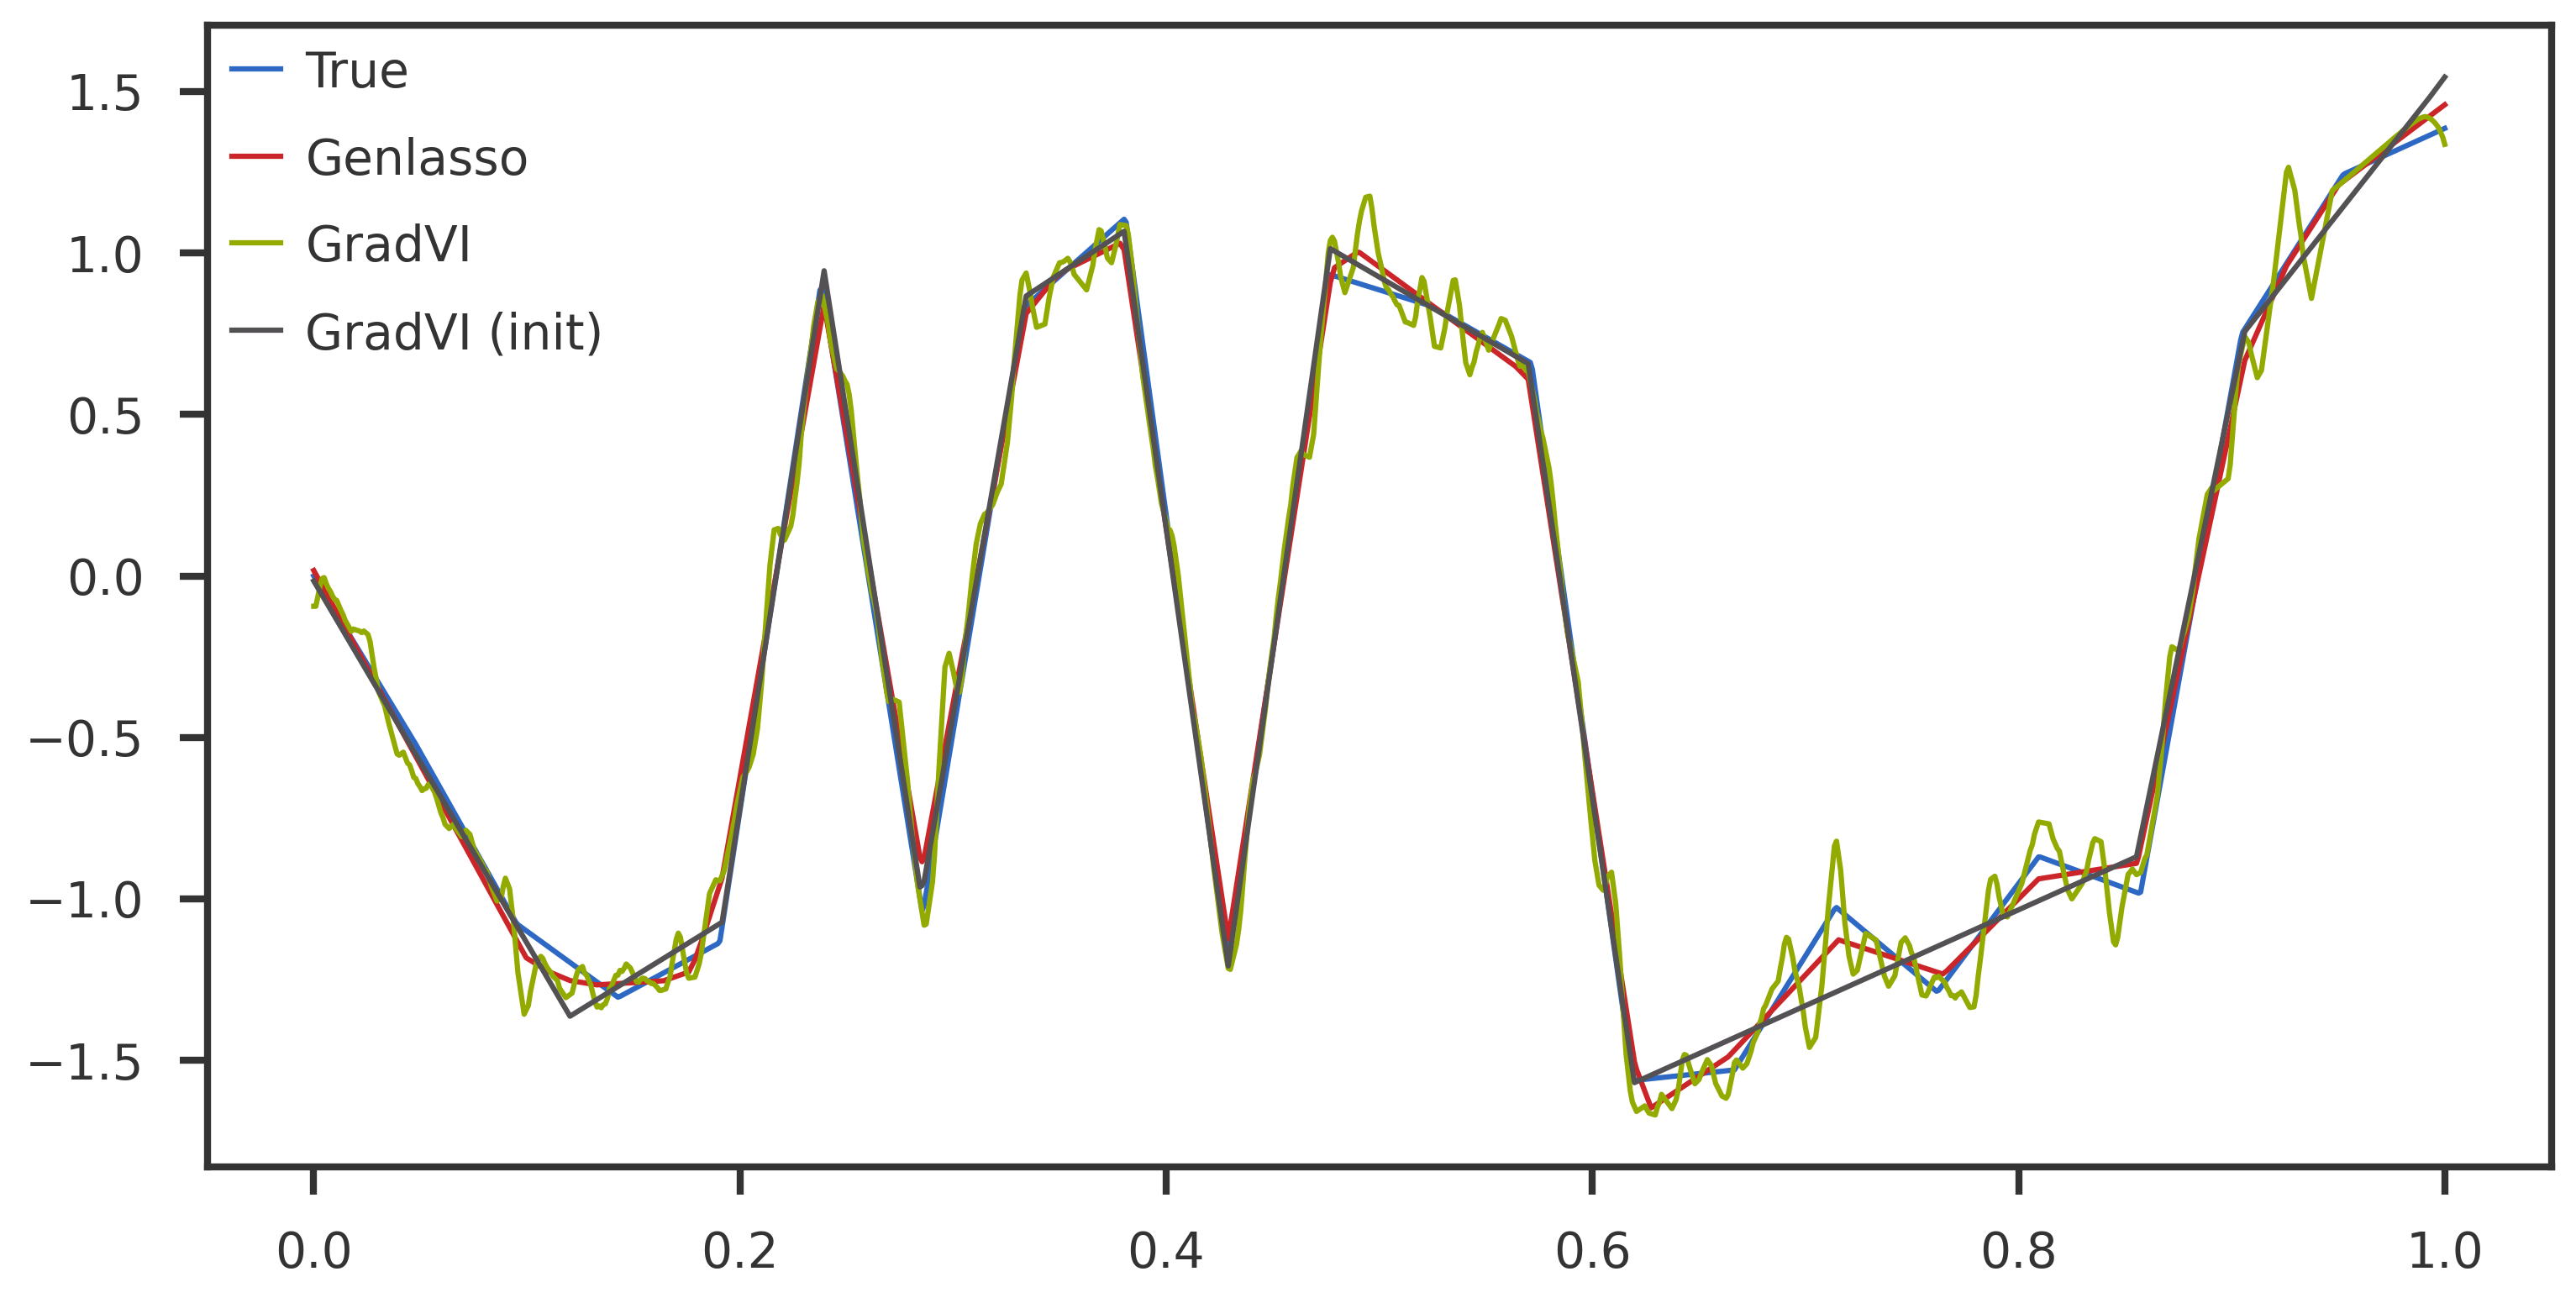

In [47]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)
#ax1.scatter(data.x, data.y, s = 2, color = 'grey')
ax1.plot(data.x, data.ytrue, label = 'True')
ax1.plot(data.x, tf_y, label = 'Genlasso')
ax1.plot(data.x, gv2.ypred, label = 'GradVI')
ax1.plot(data.x, gv1.ypred, label = 'GradVI (init)')

ax1.legend()

#fig.savefig("trendfiltering_example_gamma.pdf", bbox_inches = 'tight')
plt.show()